In [1]:
import numpy as np
import pandas as pd
import os
import math
from operator import truediv
import os
import random
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn.modules.loss import _Loss
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
seed = 42

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(seed)


windowSize = 25
batch_size = 64

def padding(X, margin=2):
    newX = np.zeros((X.shape[0] + 2*margin, X.shape[1] + 2*margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX [x_offset : X.shape[0] + x_offset, y_offset : X.shape[1] + y_offset, :] = X
    return newX

def createPatch(X, y, windowSize=windowSize):
    margin = int((windowSize-1)/2)
    zeroPaddedX = padding(X, margin=margin)

    patchesData = np.zeros((X.shape[0]*X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0

    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin: r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex += 1


    patchesData = patchesData[patchesLabels > 0, :, :, :]
    patchesLabels = patchesLabels[patchesLabels > 0]
    patchesLabels -= 1


    patchesData = patchesData.transpose((0, 3, 1, 2))

    return patchesData, patchesLabels


def applyPCA(X, numComponents=15):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX


def splitTrainTestSet(X, y, randomState=42):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.40, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test



In [4]:
from scipy.io import loadmat

In [5]:
X=loadmat('/content/drive/MyDrive/dml/Pavia-veriseti/PaviaU.mat')['paviaU']
y= loadmat('/content/drive/MyDrive/dml/Pavia-veriseti/PaviaU_gt.mat')['paviaU_gt']



In [6]:
X.shape

(610, 340, 103)

In [7]:
X=applyPCA(X)

X,y=createPatch(X,y)

print(X.shape)
print(y.shape)

(42776, 15, 25, 25)
(42776,)


# Contrastive Loss için ön işleme

In [ ]:
X_df = pd.DataFrame(X.reshape(X.shape[0], -1))
df = pd.DataFrame(X.reshape(X.shape[0], -1))
df['class'] = y.ravel()

y_df= df['class']
X_train_df,X_val_df,X_test_df,y_train_df,y_val_df,y_test_df=splitTrainTestSet(X_df,y_df)

print(X_train_df.shape)
print(X_val_df.shape)
print(X_test_df.shape)
print(y_train_df.shape)
print(y_val_df.shape)
print(y_test_df.shape)



columns = ['archor_img','postive_img','other_img','label','actual_label']
df_train_for_contrastive=pd.DataFrame(columns=columns)
df_test_for_contrastive=pd.DataFrame(columns=columns)
df_val_for_contrastive=pd.DataFrame(columns=columns)


val_df=pd.concat([X_val_df,y_val_df],axis=1)
train_df=pd.concat([X_train_df, y_train_df], axis=1)
test_df=pd.concat([X_test_df,y_test_df],axis=1)


train_df_reset_index= train_df.reset_index()
test_df_reset_index = test_df.reset_index()
val_df_reset_index = val_df.reset_index()

(12832, 9375)
(17966, 9375)
(11978, 9375)
(12832,)
(17966,)
(11978,)


In [ ]:
grouped = train_df_reset_index.groupby('class')['index'].apply(list).to_dict()

for class_label, values in grouped.items():
      i = 0
      while i < len(values) - 1:
          anchor = values[i]
          other = values[i+1]
          label = 1.0
          new_row_dict = {'archor_img': anchor, 'postive_img': anchor, 'other_img': other, 'label': label,'actual_label':class_label}
          df_train_for_contrastive= df_train_for_contrastive._append(new_row_dict, ignore_index=True)
          i += 1


In [ ]:
keys = list(grouped.keys())

for i, key in enumerate(keys):
    current_group = grouped[key]
    other_keys = [k for k in keys if k != key]
    for ind in current_group:

        random_key = random.choice(other_keys)
        other_group = grouped[random_key]
        other_ind = random.choice(other_group)
        label = 0.0
        new_row_dict = {'archor_img': ind, 'postive_img': ind, 'other_img': other_ind, 'label': label,'actual_label':key}
        df_train_for_contrastive= df_train_for_contrastive._append(new_row_dict, ignore_index=True)

In [ ]:
df_train_for_contrastive = df_train_for_contrastive.sample(frac=1).reset_index(drop=True)

In [ ]:
df_train_for_contrastive

,archor_img,postive_img,other_img,label,actual_label
0,8032.0,8032.0,1485.0,0.0,1.0
1,29246.0,29246.0,22834.0,0.0,1.0
2,23476.0,23476.0,34953.0,1.0,0.0
3,39474.0,39474.0,42565.0,1.0,1.0
4,32363.0,32363.0,28541.0,0.0,1.0
...,...,...,...,...,...
25650,5192.0,5192.0,41807.0,1.0,1.0
25651,7189.0,7189.0,8635.0,1.0,4.0
25652,41726.0,41726.0,8258.0,0.0,1.0
25653,17508.0,17508.0,20180.0,1.0,5.0


In [ ]:
df_train_for_contrastive.to_csv('train_for_contrastive_pavia.csv')

In [ ]:
grouped = test_df_reset_index.groupby('class')['index'].apply(list).to_dict()

for class_label, values in grouped.items():
      i = 0
      while i < len(values) - 1:
          anchor = values[i]
          other = values[i+1]
          label = 1.0
          new_row_dict = {'archor_img': anchor, 'postive_img': anchor, 'other_img': other, 'label': label,'actual_label':class_label}
          df_test_for_contrastive= df_test_for_contrastive._append(new_row_dict, ignore_index=True)
          i += 1


In [ ]:
keys = list(grouped.keys())

for i, key in enumerate(keys):
    current_group = grouped[key]
    other_keys = [k for k in keys if k != key]
    for ind in current_group:

        random_key = random.choice(other_keys)
        other_group = grouped[random_key]
        other_ind = random.choice(other_group)
        label = 0.0
        new_row_dict = {'archor_img': ind, 'postive_img': ind, 'other_img': other_ind, 'label': label,'actual_label':key}
        df_test_for_contrastive= df_test_for_contrastive._append(new_row_dict, ignore_index=True)


df_test_for_contrastive = df_test_for_contrastive.sample(frac=1).reset_index(drop=True)

df_test_for_contrastive.to_csv('test_for_contrastive_pavia.csv')

In [ ]:
grouped = val_df_reset_index.groupby('class')['index'].apply(list).to_dict()

for class_label, values in grouped.items():
      i = 0
      while i < len(values) - 1:
          anchor = values[i]
          other = values[i+1]
          label = 1.0
          new_row_dict = {'archor_img': anchor, 'postive_img': anchor, 'other_img': other, 'label': label,'actual_label':class_label}
          df_val_for_contrastive= df_val_for_contrastive._append(new_row_dict, ignore_index=True)
          i += 1


In [ ]:
keys = list(grouped.keys())

for i, key in enumerate(keys):
    current_group = grouped[key]
    other_keys = [k for k in keys if k != key]
    for ind in current_group:

        random_key = random.choice(other_keys)
        other_group = grouped[random_key]
        other_ind = random.choice(other_group)
        label = 0.0
        new_row_dict = {'archor_img': ind, 'postive_img': ind, 'other_img': other_ind, 'label': label,'actual_label':key}
        df_val_for_contrastive= df_val_for_contrastive._append(new_row_dict, ignore_index=True)


df_val_for_contrastive = df_val_for_contrastive.sample(frac=1).reset_index(drop=True)

df_val_for_contrastive.to_csv('val_for_contrastive_pavia.csv')

# Contrastive Ön işleme bitiş

# Verilerin Alınması

In [8]:
df_train_for_contrastive = pd.read_csv('train_for_contrastive_pavia.csv',index_col=0)
df_test_for_contrastive = pd.read_csv('test_for_contrastive_pavia.csv',index_col=0)
df_val_for_contrastive = pd.read_csv('val_for_contrastive_pavia.csv',index_col=0)

indices_train = df_train_for_contrastive.iloc[:, 1].astype(int).values
indices_test = df_test_for_contrastive.iloc[:,1].astype(int).values
indices_val = df_val_for_contrastive.iloc[:,1].astype(int).values

X_Train = X[indices_train]
X_Val = X[indices_val]
X_Test = X[indices_test]
y_Train = y[indices_train]
y_Val = y[indices_val]
y_Test = y[indices_test]

In [9]:
class HSIDataset():

    def __init__(self, datafr,X_np):
        self.data = datafr
        self.X_np = X_np


        self.anchorimages = datafr.iloc[:, 0].values
        self.labels = datafr.iloc[:, 3].values
        self.actual_label = datafr.iloc[:, 4].values
        self.otherimages = datafr.iloc[:, 2].values
        self.index = datafr.index.values

    def __len__(self):
        return len(self.anchorimages)

    def __getitem__(self, item):


        anchor_image_index = self.anchorimages[item]
        anchor_image_index=int(anchor_image_index)
        anchor_img = self.X_np[anchor_image_index]


        label = self.labels[item]

        actual_label = self.actual_label[item]

        other_image_index = self.otherimages[item]
        other_image_index=int(other_image_index)
        other_img = self.X_np[other_image_index]

        anchor_img_tensor = torch.tensor(anchor_img)
        other_img_tensor = torch.tensor(other_img)
        label_tensor = torch.tensor(label)
        actual_label_tensor = torch.tensor(actual_label)

        anchor_img_tensor=anchor_img_tensor.float()
        other_img_tensor=other_img_tensor.float()
        label_tensor=label_tensor.float()
        actual_label_tensor=actual_label_tensor.float()

        return anchor_img_tensor,other_img_tensor, label_tensor,actual_label_tensor,anchor_image_index

In [10]:
def get_train_dataset():
    train_dataset = HSIDataset(df_train_for_contrastive,X)
    return train_dataset

def get_test_dataset():
    test_dataset = HSIDataset(df_test_for_contrastive,X)
    return test_dataset

def get_val_dataset():
    val_dataset = HSIDataset(df_val_for_contrastive,X)
    return val_dataset


from torch.utils.data import DataLoader

train_dataset=get_train_dataset()


train_dl = DataLoader(train_dataset,batch_size=64,shuffle=True,num_workers=4,pin_memory=True)

val_dataset = get_val_dataset()

val_dl = DataLoader(val_dataset,batch_size=64,shuffle=True,num_workers=4,pin_memory=True)

test_dataset = get_test_dataset()

test_dl = DataLoader(test_dataset,batch_size=64,shuffle=True,num_workers=4,pin_memory=True)


# Network ve Loss functionu

In [11]:
def l2_norm(x, y):
    return ((x - y) ** 2).sum(1)

In [12]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0, metric=l2_norm, reduction='mean'):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.metric = metric
        if reduction == 'mean':
            self.reduction = torch.mean
        elif reduction == 'sum':
            self.reduction = torch.sum

    @staticmethod
    def normalize_x(x):
        z = torch.sqrt(torch.sum(x ** 2, dim=1, keepdim=True))
        return x / z

    def forward(self, x_p, x_q, y, normalize=True):
        if normalize:
            x_p = self.normalize_x(x_p)
            x_q = self.normalize_x(x_q)
        distance = self.metric(x_p, x_q)

        loss = y * distance + (1 - y) * F.relu(self.margin - distance)
        loss = self.reduction(loss)

        return loss

In [13]:
class CNNetwork(nn.Module):
    def __init__(self):
        super(CNNetwork, self).__init__()

        self.conv1 = nn.Conv2d(15, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc4 = nn.Linear(128 * 3 * 3, 512)
        self.relu4 = nn.ReLU(inplace=True)
        self.fc5 = nn.Linear(512, 128)


    def forward(self, x):

        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = x.view(x.size(0), -1)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)


        return x




class ClassificationNN(nn.Module):
    def __init__(self):
        super(ClassificationNN, self).__init__()
        self.fc8 = nn.Linear(128,256)
        self.relu1=nn.ReLU(inplace=True)
        self.fc9=nn.Linear(256,512)
        self.relu2=nn.ReLU(inplace=True)
        self.fc10=nn.Linear(512,128)
        self.relu3=nn.ReLU(inplace=True)
        self.fc11=nn.Linear(128,64)
        self.relu4=nn.ReLU(inplace=True)
        self.fc6 = nn.Linear(64, 32)
        self.relu = nn.ReLU(inplace=True)
        self.fc7 = nn.Linear(32, 9)

    def forward(self, x):

        x = self.fc8(x)
        x=self.relu1(x)
        x = self.fc9(x)
        x=self.relu2(x)
        x = self.fc10(x)
        x=self.relu3(x)
        x = self.fc11(x)
        x=self.relu4(x)
        x = self.fc6(x)
        x = self.relu(x)
        x = self.fc7(x)


        return x







# Model Train

In [14]:
from tqdm import tqdm


def evaluate(model, val_dl, loss_fn, device):
    model.eval()
    with torch.no_grad():
        running_loss = []
        running_acc = []


        for step, (anchor_img, other_img,label,_,_) in enumerate(tqdm(val_dl, desc="Evaluating", leave=False)):
            anchor_img = anchor_img.to(device)
            other_img = other_img.to(device)
            label = label.to(device)

            anchor_output = model(anchor_img)
            other_output = model(other_img)


            loss = loss_fn(anchor_output, other_output,label)




            running_loss.append(loss.item())



        avg_loss = sum(running_loss) / len(running_loss)


    return avg_loss


def train(model, train_dl, val_dl, loss_fn, optimizer, device):


    train_loss = []
    val_loss = []

    model.train()
    best_val_acc = 0.0
    for epoch in tqdm(range(20), desc="Epochs"):
        running_loss = []

        for step, (anchor_img,other_img,label,_,_) in enumerate(tqdm(train_dl, desc="Training", leave=False)):
            anchor_img = anchor_img.to(device)
            other_img = other_img.to(device)
            label = label.to(device)

            anchor_output = model(anchor_img)
            other_output = model(other_img)



            loss = loss_fn(anchor_output,other_output,label)

            running_loss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        avg_loss = sum(running_loss) / len(running_loss)



        train_loss.append(avg_loss)



        eval_loss = evaluate(model, val_dl, loss_fn, device)


        val_loss.append(eval_loss)


        print(f"Epoch {epoch+1}/{20} - Training loss: {avg_loss:.4f}, Validation loss: {eval_loss:.4f}")




    return train_loss, val_loss




In [15]:
device = torch.device("cuda")
model = CNNetwork().to(device)
Optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = ContrastiveLoss()

In [16]:
train_loss, val_los = train(model, train_dl, val_dl, loss_fn, Optimizer, device)

Training: 100%|█████████▉| 399/401 [00:04<00:00, 126.96it/s]
                                                            
Epochs:   5%|▌         | 1/20 [00:09<02:53,  9.16s/it]

Epoch 1/20 - Training loss: 0.1082, Validation loss: 0.0766



Training:  98%|█████████▊| 391/401 [00:03<00:00, 117.16it/s]
                                                            
Epochs:  10%|█         | 2/20 [00:16<02:26,  8.16s/it]

Epoch 2/20 - Training loss: 0.0652, Validation loss: 0.0662



Training:  98%|█████████▊| 393/401 [00:03<00:00, 102.94it/s]
                                                            
Epochs:  15%|█▌        | 3/20 [00:24<02:14,  7.91s/it]

Epoch 3/20 - Training loss: 0.0620, Validation loss: 0.0607



Training:  99%|█████████▊| 395/401 [00:03<00:00, 128.32it/s]
                                                            
Epochs:  20%|██        | 4/20 [00:31<02:00,  7.55s/it]

Epoch 4/20 - Training loss: 0.0489, Validation loss: 0.0501



Training:  99%|█████████▊| 395/401 [00:03<00:00, 129.21it/s]
                                                            
Epochs:  25%|██▌       | 5/20 [00:38<01:50,  7.38s/it]

Epoch 5/20 - Training loss: 0.0468, Validation loss: 0.0496



Training:  99%|█████████▉| 396/401 [00:03<00:00, 128.50it/s]
                                                            
Epochs:  30%|███       | 6/20 [00:45<01:41,  7.23s/it]

Epoch 6/20 - Training loss: 0.0467, Validation loss: 0.0460



Training: 100%|█████████▉| 400/401 [00:03<00:00, 132.05it/s]
                                                            
Epochs:  35%|███▌      | 7/20 [00:52<01:33,  7.16s/it]

Epoch 7/20 - Training loss: 0.0559, Validation loss: 0.0600



Training:  99%|█████████▊| 395/401 [00:03<00:00, 125.80it/s]
                                                            
Epochs:  40%|████      | 8/20 [00:59<01:25,  7.10s/it]

Epoch 8/20 - Training loss: 0.0559, Validation loss: 0.0501



Training:  97%|█████████▋| 387/401 [00:03<00:00, 130.49it/s]
                                                            
Epochs:  45%|████▌     | 9/20 [01:06<01:17,  7.07s/it]

Epoch 9/20 - Training loss: 0.0434, Validation loss: 0.0459



Training:  98%|█████████▊| 393/401 [00:03<00:00, 128.38it/s]
                                                            
Epochs:  50%|█████     | 10/20 [01:13<01:10,  7.08s/it]

Epoch 10/20 - Training loss: 0.0432, Validation loss: 0.0459



Training:  99%|█████████▉| 398/401 [00:03<00:00, 130.34it/s]
                                                            
Epochs:  55%|█████▌    | 11/20 [01:20<01:03,  7.06s/it]

Epoch 11/20 - Training loss: 0.0432, Validation loss: 0.0458



Training: 100%|██████████| 401/401 [00:03<00:00, 134.22it/s]
                                                            
Epochs:  60%|██████    | 12/20 [01:27<00:56,  7.10s/it]

Epoch 12/20 - Training loss: 0.0432, Validation loss: 0.0457



Training:  98%|█████████▊| 392/401 [00:03<00:00, 127.23it/s]
                                                            
Epochs:  65%|██████▌   | 13/20 [01:34<00:49,  7.08s/it]

Epoch 13/20 - Training loss: 0.0439, Validation loss: 0.0411



Training:  98%|█████████▊| 393/401 [00:03<00:00, 121.90it/s]
                                                            
Epochs:  70%|███████   | 14/20 [01:41<00:42,  7.09s/it]

Epoch 14/20 - Training loss: 0.0402, Validation loss: 0.0377



Training: 100%|█████████▉| 399/401 [00:03<00:00, 128.28it/s]
                                                            
Epochs:  75%|███████▌  | 15/20 [01:48<00:35,  7.04s/it]

Epoch 15/20 - Training loss: 0.0388, Validation loss: 0.0381



Training:  97%|█████████▋| 390/401 [00:03<00:00, 118.35it/s]
                                                            
Epochs:  80%|████████  | 16/20 [01:55<00:28,  7.08s/it]

Epoch 16/20 - Training loss: 0.0481, Validation loss: 0.0375



Training: 100%|█████████▉| 400/401 [00:03<00:00, 132.16it/s]
                                                            
Epochs:  85%|████████▌ | 17/20 [02:02<00:21,  7.04s/it]

Epoch 17/20 - Training loss: 0.0154, Validation loss: 0.0095



Training:  98%|█████████▊| 391/401 [00:03<00:00, 121.11it/s]
                                                            
Epochs:  90%|█████████ | 18/20 [02:09<00:14,  7.07s/it]

Epoch 18/20 - Training loss: 0.0060, Validation loss: 0.0010



Training:  98%|█████████▊| 392/401 [00:03<00:00, 128.53it/s]
                                                            
Epochs:  95%|█████████▌| 19/20 [02:16<00:07,  7.04s/it]

Epoch 19/20 - Training loss: 0.0030, Validation loss: 0.0014



Training:  97%|█████████▋| 389/401 [00:03<00:00, 128.07it/s]
                                                            
Epochs: 100%|██████████| 20/20 [02:23<00:00,  7.20s/it]

Epoch 20/20 - Training loss: 0.0003, Validation loss: 0.0004


In [17]:
torch.save(model.state_dict(), 'pavia_contrastive_model_.pth')

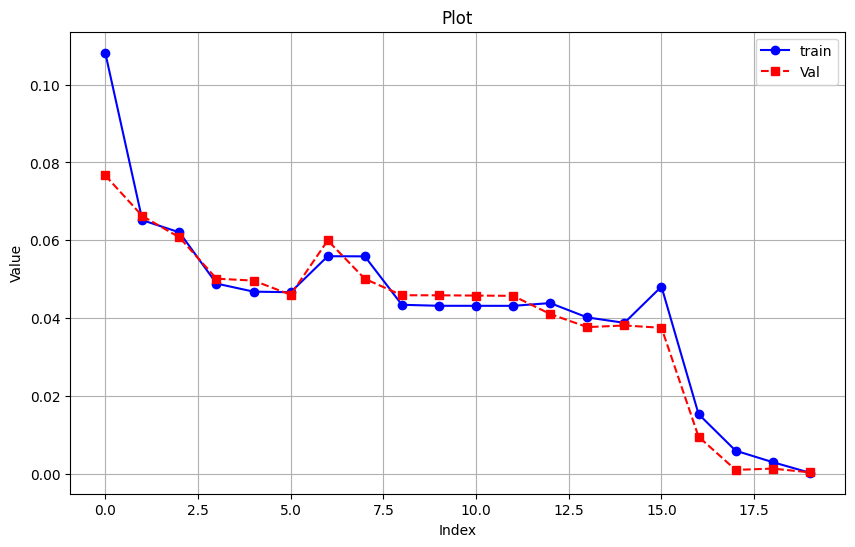

In [18]:
indices =list(range(len(train_loss)))

plt.figure(figsize=(10, 6))
plt.plot(indices, train_loss, marker='o', linestyle='-', color='b', label='train')
plt.plot(indices, val_los, marker='s', linestyle='--', color='r', label='Val')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot')
plt.legend()
plt.grid(True)
plt.show()

# Çıkarılan özellikler hakkında işlemler

In [19]:
class FeatureDataset():
    def __init__(self, feature, feature_labels):
        self.data = feature
        self.labels = feature_labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


model.eval()
val_features = []
val_labels = []
seen_anchors = set()

with torch.no_grad():
    for anchor_img, _, _, anchor_label,anchor_index in val_dl:
        size_b = anchor_img.size(0)
        for i in range(size_b):
            if anchor_index[i].item() not in seen_anchors:
                seen_anchors.add(anchor_index[i].item())
                img = anchor_img[i].unsqueeze(0).to(device)
                features = model(img)
                val_features.append(features)
                val_labels.append(anchor_label[i])

val_features = torch.cat(val_features, dim=0)

val_labels = [label.unsqueeze(0) for label in val_labels]
val_labels = torch.cat(val_labels, dim=0)

dataset_train = FeatureDataset(val_features, val_labels)

Feature_train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True)




model.eval()
test_features = []
test_labels = []
seen_anchors = set()

with torch.no_grad():
    for anchor_img, _, _, anchor_label,anchor_index in test_dl:
        size_b = anchor_img.size(0)
        for i in range(size_b):
            if anchor_index[i] not in seen_anchors:
                seen_anchors.add(anchor_index[i])
                img = anchor_img[i].unsqueeze(0).to(device)
                features = model(img)
                test_features.append(features)
                test_labels.append(anchor_label[i])

test_features = torch.cat(test_features, dim=0)
test_labels = [label.unsqueeze(0) for label in test_labels]
test_labels = torch.cat(test_labels, dim=0)

dataset_test = FeatureDataset(test_features, test_labels)

Feature_test_loader = DataLoader(dataset_test, batch_size=64, shuffle=True)

# Sınıflandırma Aşaması

In [20]:
classificationModel = ClassificationNN()
optimizer_feature = optim.Adam(classificationModel.parameters(), lr=0.001)
loss_for_classification = nn.CrossEntropyLoss()


In [21]:
def evaluate_classification(model, test_class_dl, clas_loss_fn, device):
    model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_class_dl:
            targets= targets.type(torch.LongTensor)
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = clas_loss_fn(outputs, targets)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    average_loss = total_loss / len(test_class_dl)
    accuracy = (correct / total) * 100

    return average_loss, accuracy


from tqdm import tqdm
from sklearn.metrics import accuracy_score

def train_classification(model_classification, feat_train_loader, feat_criterion, feat_optimizer, device, test_class_dl):
    model_classification.to(device)
    model_classification.train()

    loss_list = []
    epoch_accuracies = []
    evaluation_losses = []
    evaluation_accuracies = []

    for epoch in tqdm(range(20), desc="Epochs"):
        model_classification.train()
        all_labels = []
        all_predictions = []
        epoch_loss_list = []

        for inputs, labels in feat_train_loader:
            labels = labels.type(torch.LongTensor)
            inputs, labels = inputs.to(device), labels.to(device)

            feat_optimizer.zero_grad()
            outputs = model_classification(inputs)
            loss = feat_criterion(outputs, labels)
            loss.backward()
            feat_optimizer.step()

            epoch_loss_list.append(loss.item())
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_predictions)
        epoch_accuracies.append(accuracy)
        loss_list.extend(epoch_loss_list)

        eval_loss, eval_accuracy = evaluate_classification(model_classification, test_class_dl, feat_criterion, device)
        evaluation_losses.append(eval_loss)
        evaluation_accuracies.append(eval_accuracy)

        print(f"Epoch {epoch+1}/{20}, Training Loss: {sum(epoch_loss_list)/len(epoch_loss_list):.4f}, Training Accuracy: {accuracy:.4f}")
        print(f"Validation Loss: {eval_loss:.4f}, Validation Accuracy: {eval_accuracy:.2f}%")

    return loss_list, epoch_accuracies, evaluation_losses, evaluation_accuracies


In [22]:
for param in classificationModel.parameters():
    param.requires_grad = True

In [23]:
loss_list, epoch_accuracies, evaluation_losses, evaluation_accuracies = train_classification(classificationModel,Feature_train_loader,loss_for_classification,optimizer_feature,device,Feature_test_loader)

Epochs:   5%|▌         | 1/20 [00:01<00:27,  1.43s/it]

Epoch 1/20, Training Loss: 0.0512, Training Accuracy: 0.9855
Validation Loss: 0.0035, Validation Accuracy: 99.97%


Epochs:  10%|█         | 2/20 [00:02<00:23,  1.29s/it]

Epoch 2/20, Training Loss: 0.0022, Training Accuracy: 0.9992
Validation Loss: 0.0027, Validation Accuracy: 99.97%


Epochs:  15%|█▌        | 3/20 [00:03<00:21,  1.25s/it]

Epoch 3/20, Training Loss: 0.0002, Training Accuracy: 0.9999
Validation Loss: 0.0021, Validation Accuracy: 99.97%


Epochs:  20%|██        | 4/20 [00:05<00:19,  1.24s/it]

Epoch 4/20, Training Loss: 0.0002, Training Accuracy: 0.9999
Validation Loss: 0.0018, Validation Accuracy: 99.98%


Epochs:  25%|██▌       | 5/20 [00:06<00:18,  1.23s/it]

Epoch 5/20, Training Loss: 0.0001, Training Accuracy: 0.9999
Validation Loss: 0.0008, Validation Accuracy: 99.98%


Epochs:  30%|███       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 6/20, Training Loss: 0.0277, Training Accuracy: 0.9985
Validation Loss: 4.3773, Validation Accuracy: 43.96%


Epochs:  35%|███▌      | 7/20 [00:08<00:16,  1.25s/it]

Epoch 7/20, Training Loss: 0.0860, Training Accuracy: 0.9958
Validation Loss: 0.0405, Validation Accuracy: 99.97%


Epochs:  40%|████      | 8/20 [00:10<00:14,  1.24s/it]

Epoch 8/20, Training Loss: 0.0003, Training Accuracy: 0.9999
Validation Loss: 0.0410, Validation Accuracy: 99.97%


Epochs:  45%|████▌     | 9/20 [00:11<00:13,  1.24s/it]

Epoch 9/20, Training Loss: 0.0002, Training Accuracy: 0.9999
Validation Loss: 0.0412, Validation Accuracy: 99.97%


Epochs:  50%|█████     | 10/20 [00:12<00:12,  1.23s/it]

Epoch 10/20, Training Loss: 0.0001, Training Accuracy: 0.9999
Validation Loss: 0.0405, Validation Accuracy: 99.97%


Epochs:  55%|█████▌    | 11/20 [00:13<00:10,  1.22s/it]

Epoch 11/20, Training Loss: 0.0001, Training Accuracy: 0.9999
Validation Loss: 0.0404, Validation Accuracy: 99.97%


Epochs:  60%|██████    | 12/20 [00:14<00:09,  1.22s/it]

Epoch 12/20, Training Loss: 0.0001, Training Accuracy: 0.9999
Validation Loss: 0.0392, Validation Accuracy: 99.97%


Epochs:  65%|██████▌   | 13/20 [00:16<00:08,  1.22s/it]

Epoch 13/20, Training Loss: 0.0000, Training Accuracy: 1.0000
Validation Loss: 0.0402, Validation Accuracy: 99.97%


Epochs:  70%|███████   | 14/20 [00:17<00:07,  1.21s/it]

Epoch 14/20, Training Loss: 0.0001, Training Accuracy: 0.9999
Validation Loss: 0.0393, Validation Accuracy: 99.97%


Epochs:  75%|███████▌  | 15/20 [00:18<00:06,  1.22s/it]

Epoch 15/20, Training Loss: 0.0001, Training Accuracy: 0.9999
Validation Loss: 0.0392, Validation Accuracy: 99.97%


Epochs:  80%|████████  | 16/20 [00:19<00:04,  1.23s/it]

Epoch 16/20, Training Loss: 0.0000, Training Accuracy: 1.0000
Validation Loss: 0.0385, Validation Accuracy: 99.98%


Epochs:  85%|████████▌ | 17/20 [00:21<00:03,  1.23s/it]

Epoch 17/20, Training Loss: 0.0000, Training Accuracy: 1.0000
Validation Loss: 0.0384, Validation Accuracy: 99.98%


Epochs:  90%|█████████ | 18/20 [00:22<00:02,  1.23s/it]

Epoch 18/20, Training Loss: 0.0000, Training Accuracy: 1.0000
Validation Loss: 0.0384, Validation Accuracy: 99.98%


Epochs:  95%|█████████▌| 19/20 [00:23<00:01,  1.22s/it]

Epoch 19/20, Training Loss: 0.0000, Training Accuracy: 1.0000
Validation Loss: 0.0381, Validation Accuracy: 99.98%


Epochs: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it]

Epoch 20/20, Training Loss: 0.0000, Training Accuracy: 1.0000
Validation Loss: 0.0375, Validation Accuracy: 99.98%


In [28]:
torch.save(classificationModel.state_dict(), 'pavia_classification_contrastive_model_.pth')

# Başarıların Çizdirilmesi

In [24]:
X_tensor = torch.tensor(X)
X_tensor=X_tensor.float()
X_tensor=X_tensor.to(device)

In [25]:
y_pred_array = []
i=0
while i <  X_tensor.shape[0]:
      a =  X_tensor[i]
      a = a.unsqueeze(0)
      output=model(a)
      clas_tahmin = classificationModel(output)
      clas_tahmin =clas_tahmin.argmax().float()
      clas_tahmin=clas_tahmin.item()
      y_pred_array.append(clas_tahmin)
      i+=1


In [26]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score, f1_score

In [27]:
s=accuracy_score(y,y_pred_array)
c=cohen_kappa_score(y,y_pred_array)
f1=f1_score(y,y_pred_array,average='weighted')
print(s,c,f1)

0.9999532448101739 0.9999380454411951 0.9999532384314099


In [29]:
gt_2=loadmat('/content/drive/MyDrive/dml/Pavia-veriseti/PaviaU_gt.mat')['paviaU_gt']


In [30]:
gt_2=gt_2.reshape(-1)

In [31]:
c=0
d=0
i=0
for i in range(207400):
    if gt_2[i] != 0:
              gt_2[i]=(y_pred_array[d] + 1)
              d += 1

In [32]:
gt_2=gt_2.reshape(610,-1)

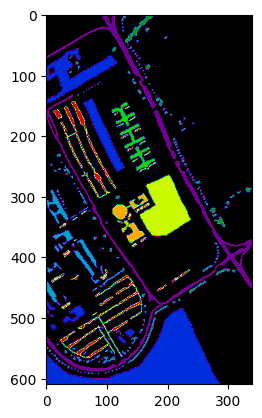

In [33]:

plt.imshow(gt_2, cmap='nipy_spectral')
plt.show()

In [34]:
gt_3= loadmat('/content/drive/MyDrive/dml/Pavia-veriseti/PaviaU_gt.mat')['paviaU_gt']

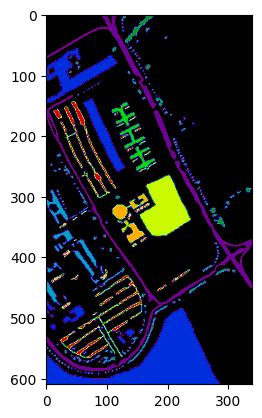

In [35]:
plt.imshow(gt_3,cmap='nipy_spectral')
plt.show()